<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Daniel Minaya
- Nombre de alumno 2:


### **Link de repositorio de GitHub:** `https://github.com/DanielMinaya1/MDS7202`

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer material del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

seed = 42

df = pd.read_csv('diabetes_data.csv')

## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?. 

In [2]:
!pip install xgboost

### 2.1 Análisis exploratorio

In [3]:
df.head()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Vemos la cantidad de elementos únicos por columna
unique_values = []
for col in df.columns:
    unique_values.append(df[col].nunique())
    
unique_df = pd.DataFrame({
    'columns': df.columns,
    'unique_values': unique_values
})

unique_df

,columns,unique_values
0,Age,13
1,Sex,2
2,HighChol,2
3,CholCheck,2
4,BMI,80
5,Smoker,2
6,HeartDiseaseorAttack,2
7,PhysActivity,2
8,Fruits,2
9,Veggies,2


>Vemos que la mayoría de columnas toman dos valores únicos que pueden ser 0 o 1, indicando que son variables binarias, así que estas variables no serán preprocesadas, y las dejaremos así para el modelo.

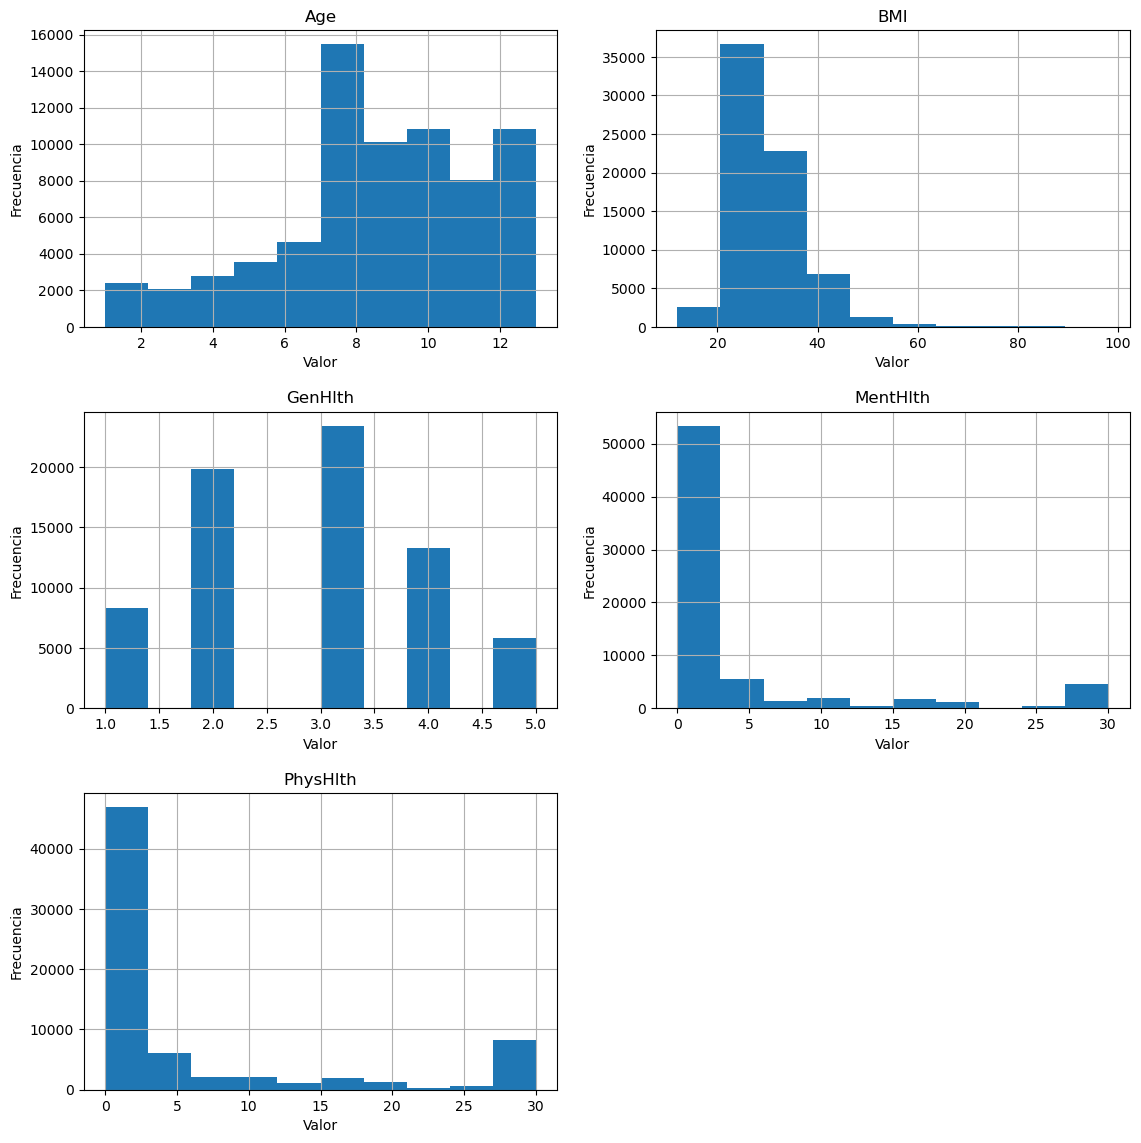

In [5]:
# Definimos las variables binarias y no binarias 
non_binary_columns = ['Age', 'BMI', 'GenHlth', 'MentHlth', 'PhysHlth']
binary_columns = [col for col in df.columns if col not in non_binary_columns]

# Ploteamos los histogramas de las variables no binarias
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
fig.tight_layout(pad=4)

for i, col in enumerate(non_binary_columns):
    row_idx = i // 2
    col_idx = i % 2
    ax = axes[row_idx, col_idx]

    df[col].hist(ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frecuencia')

fig.delaxes(axes[-1, -1])

plt.show()

>Para Age, BMI y GenHlth utilizaremos StandardScaler mientras que para el resto de variables utilizaremos MinMaxScaler, debido a que estas últimas variable no siguen una distribución normal.

### 2.2 Separación de datos

In [6]:
# Separamos features y labels
X, y = df.drop(columns=['Diabetes']), df['Diabetes']

# Separamos en train (70%), validation (20%) y split (10%)
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, 
                                                          test_size=0.3, 
                                                          random_state=seed, 
                                                          shuffle=True,
                                                         )
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, 
                                                test_size=0.33, 
                                                random_state=seed,
                                                shuffle=True,
                                               )

print("Train:", len(X_train))
print("Val:", len(X_val))
print("Test:", len(X_test))

Train: 49484
Val: 14209
Test: 6999


### 2.3 ColumnTransformers

In [7]:
# Definimos las columnas procesadas con StandardScaler
std_features = [
    'Age',
    'BMI',
]

# Definimos las columnas procesadas con MinMaxScaler
minmax_features = [
    'GenHlth', 
    'MentHlth', 
    'PhysHlth',
] 

# Definimos el preprocesador para las columnas
preprocessor = ColumnTransformer(
    transformers = [
        ('std', StandardScaler(), std_features),
        ('minmax', MinMaxScaler(), minmax_features)
    ],
    # Mantenemos el resto de columnas tal cual
    remainder = 'passthrough'
).set_output(transform='pandas')

### 2.4  Generación de Pipelines

In [8]:
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std', StandardScaler(),
                                                  ['Age', 'BMI']),
                                                 ('minmax', MinMaxScaler(),
                                                  ['GenHlth', 'MentHlth',
                                                   'PhysHlth'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_sto...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [9]:
# Predecimos
y_pred_xgb = pipeline_xgb.predict(X_val)

# Mostrar métricas de clasificación
print(classification_report(y_val, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.77      0.71      0.74      7143
         1.0       0.73      0.79      0.76      7066

    accuracy                           0.75     14209
   macro avg       0.75      0.75      0.75     14209
weighted avg       0.75      0.75      0.75     14209



>Lo primero que podemos notar es que el dataset está balanceado, y las métricas obtenidas no son del todo malas.
>
>Las métricas quieren explicar ciertas cualidades del clasificador. Precision nos dice la proporción de verdaderos positivos sobre la suma de verdaderos positivos y falsos positivos. Mide la exactitud de las predicciones positivas. Recall nos dice la proporción de verdaderos positivos sobre la suma de verdaderos positivos y falsos negativos. Mide la capacidad del modelo para capturar todos los casos positivos. Por último, el F1-score es la media armónica de precisión y recall, y proporciona una métrica que toma en cuenta el equilibrio entre precisión y recall.
>
>Como nuestro objetivo es detectar diabetes, entonces es muy importante identificar todos los casos positivos sin importar que podemos identificar un caso negativo como positivo, es decir, nuestro modelo debería tener un recall alto, sin importar si precision no lo es tanto. Aunque, claramente necesitamos un modelo que al menos tenga un accuracy decente, pero maximizar el recall sería la prioridad para nuestro problema.
>
>Por último, estas métricas nos indican que tan bueno es el modelo para clasificar según los datos entregados, sin embargo, no nos indican la importancia de cada feature en la clasificación, sin embargo, algunos clasificadores tienen el atributo feature_importances que nos entregan precisamente el peso de cada feature.

## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

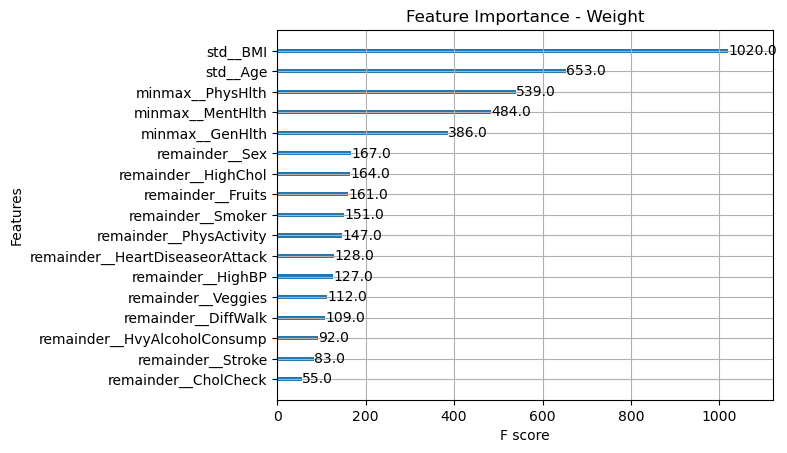

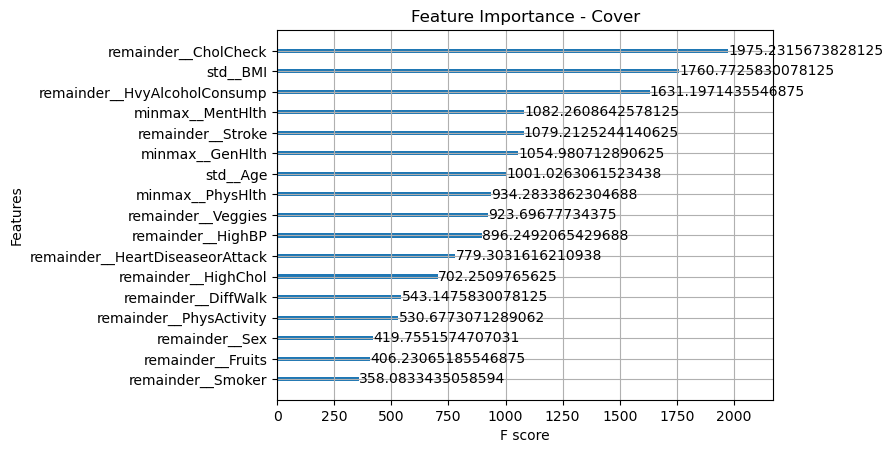

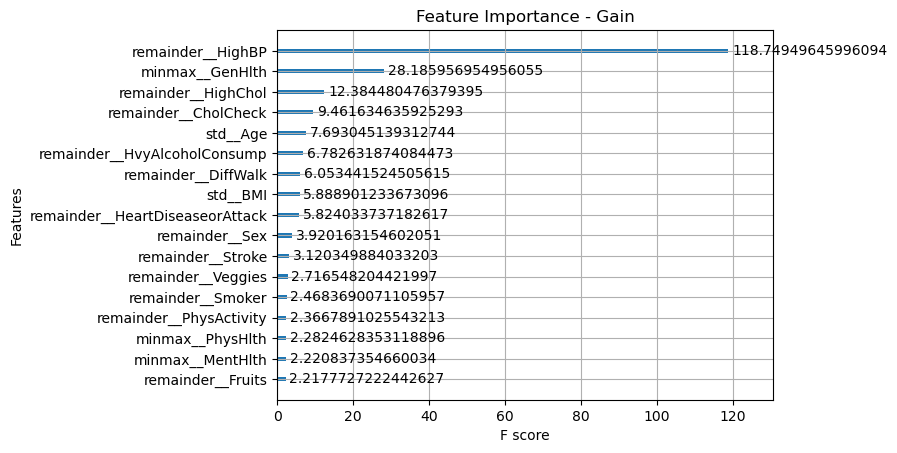

In [10]:
# Ploteamos importancia de features con 'weight', 'cover', y 'gain'
plot_importance(pipeline_xgb.named_steps['classifier'], importance_type='weight')
plt.title('Feature Importance - Weight')
plt.show()

plot_importance(pipeline_xgb.named_steps['classifier'], importance_type='cover')
plt.title('Feature Importance - Cover')
plt.show()

plot_importance(pipeline_xgb.named_steps['classifier'], importance_type='gain')
plt.title('Feature Importance - Gain')
plt.show()

>Los resultados obtenidos no son compatibles entre sí debido a que los métodos calculan la importancia de los features de manera distinta.
>
>* Weight: se calcula como la frecuencia del atributo en los árboles del modelo.
>* Cover: es la proporción entre el número de observaciones que están asociadas con cada atributo, es decir, representa la cantidad de datos que son influenciados por el atributo.
>* Gain: indica la contribución relativa de cada atributo a la predicción del modelo, es decir, mide la mejora del desempeño del modelo que cada atributo aporta.
>
>Estos resultados nos entregan las características más importantes para el clasificador, sin embargo, esto solo es a nivel global, ya que no nos ofrecen una interpretación completa de las relaciones entre las característica y la variable objetivo. Más aún, nos interesaría entender las características mas relevantes para una predicción específica, es decir, obtener una interpretabilidad más local, pero estos métodos no nos proveen de este tipo de interpretabilidad.

## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

In [11]:
result = permutation_importance(pipeline_xgb, X_test, y_test, n_repeats=30, random_state=seed)
result

{'importances_mean': array([0.02868029, 0.00313854, 0.01188741, 0.00450064, 0.03651474,
        0.00240511, 0.00523408, 0.00012859, 0.00240034, 0.0018336 ,
        0.00255275, 0.05793209, 0.00259085, 0.00341954, 0.00397676,
        0.00167643, 0.01856456]),
 'importances_std': array([0.00286965, 0.00125509, 0.00216226, 0.0009243 , 0.00252471,
        0.00133118, 0.00153861, 0.00090691, 0.00097771, 0.00084615,
        0.00079099, 0.00373304, 0.00127299, 0.00164606, 0.00133832,
        0.00093831, 0.00219738]),
 'importances': array([[ 0.03386198,  0.03157594,  0.02986141,  0.03014716,  0.02828976,
          0.02857551,  0.02743249,  0.03086155,  0.03157594,  0.03257608,
          0.02614659,  0.0324332 ,  0.02514645,  0.02843263,  0.02957565,
          0.03143306,  0.02500357,  0.02743249,  0.02657523,  0.02500357,
          0.02914702,  0.02657523,  0.03114731,  0.02743249,  0.0292899 ,
          0.03229033,  0.02757537,  0.02614659,  0.02028861,  0.02857551],
        [ 0.00271467,  0.

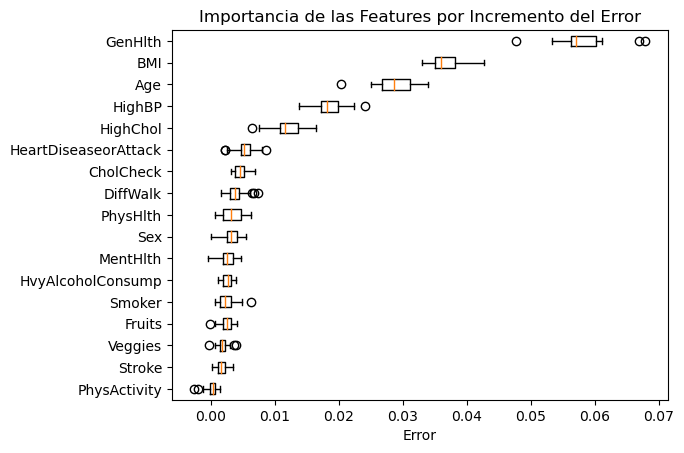

In [12]:
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=np.array(df.columns)[perm_sorted_idx],
)
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

>El método de permutación evalua la importancia de las características al permutar aleatoriamente los valores de una característica y medir cómo afecta esto al rendimiento del modelo, es decir, se evalua el desempeño del modelo según una métrica con los datos originales y luego se evalua el desempeño cuando una de las características ha sido permutado aleatoriamente.
>
>En el gráfico anterior podemos ver las características con mayor impacto son GenHlth, BMI, Age, HighBP y HighCol. Estas variables causan una mayor disminución en el rendimiento del modelo al permutar sus valores. En el contexto real, tenemos que BMI corresponde al índice de masa corporal, HighBP corresponde a alta presión sanguínea y HighCOl corresponde a alto nivel de colesterol, por lo que es razonable que estas variables sean las más relevantes para detectar diabetes de un paciente.
>
>Podemos ver que los resultados son similares a los obtenidos por el método Gain, que también considera HighBP, GenHlth, HighCol y Age como las más importantes, sin embargo el orden varía. Mientras que con los otros métodos no se obtienen resultados similares. Las características obtenidas por el método de permutación deberían ser más confiables debido a aleatoriedad del método, es decir, este método debería ser más robusto y entregar mejores resultados.
>
>Dentro de las ventajas de este método tenemos la robustez, es decir, este método es menos sensible a sesgos y suposiciones sobre la distribución de los datos. Este método es flexible ya que puede aplicarse a cualquier modelo de clasificación y además es fácil de interpretar. 
>
>Dentro de las desventajas tenemos que depende de la métrica del modelo, se pueden generar sesgos si hay variables correlacionadas y peor aún, la importancia de una característica podría dividirse con alguna otra característica correlacionada provocando que los resultados no sean precisos.

## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [13]:
!pip install shap

In [14]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [15]:
import shap

explainer = shap.TreeExplainer(pipeline_xgb.named_steps['classifier'])
shap_values = explainer(X_train)

shap_values.values

[00:24:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


array([[-0.01949269,  0.00955817,  0.5681789 , ..., -0.07742505,
         0.00679887,  0.21861672],
       [ 0.3983583 , -0.17394643,  0.8765831 , ...,  0.18924221,
         0.02078078,  0.4660962 ],
       [ 0.2517837 , -0.12572105,  0.6650182 , ...,  0.1296633 ,
         0.0224335 ,  0.3223677 ],
       ...,
       [-0.06207976, -0.04892381,  0.56303537, ..., -0.12329577,
        -0.20495006,  0.20554361],
       [ 0.39757228,  0.54407257, -0.9713529 , ...,  0.02738125,
         0.01632205,  0.33966973],
       [ 0.33158743,  0.78670955, -0.86773443, ..., -0.02665611,
        -0.00993133, -0.5108364 ]], dtype=float32)

>Cada número en el resultado de los SHAP values representa la contribución de una característica específica para una predicción particular. Estos valores representan cómo cada característica contribuye a la diferencia entre la predicción del modelo y la predicción promedio del modelo para todo el dataset.
>
>Un valor positivo indica que la presencia de esa característica contribuye de manera positiva a la clasificación, es decir, aumenta la predicción del modelo en comparación con la predicción promedio. Un valor negativo indica que la ausencia de esa característica contribuye de manera positiva a la clasificación, es decir, al eliminarla aumenta la preidcción del modelo en comparación con la predicción promeido. Por último, un valor nulo indica que la característica no tiene impacto en la clasificación en comparación a la predicción promedio.

### 5.2 Aporte local (0.4 puntos)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes? 
- ¿Existe algún patrón común entre las instancias analizadas? 
- ¿Es posible generalizar estas conclusiones a todo el dataset?

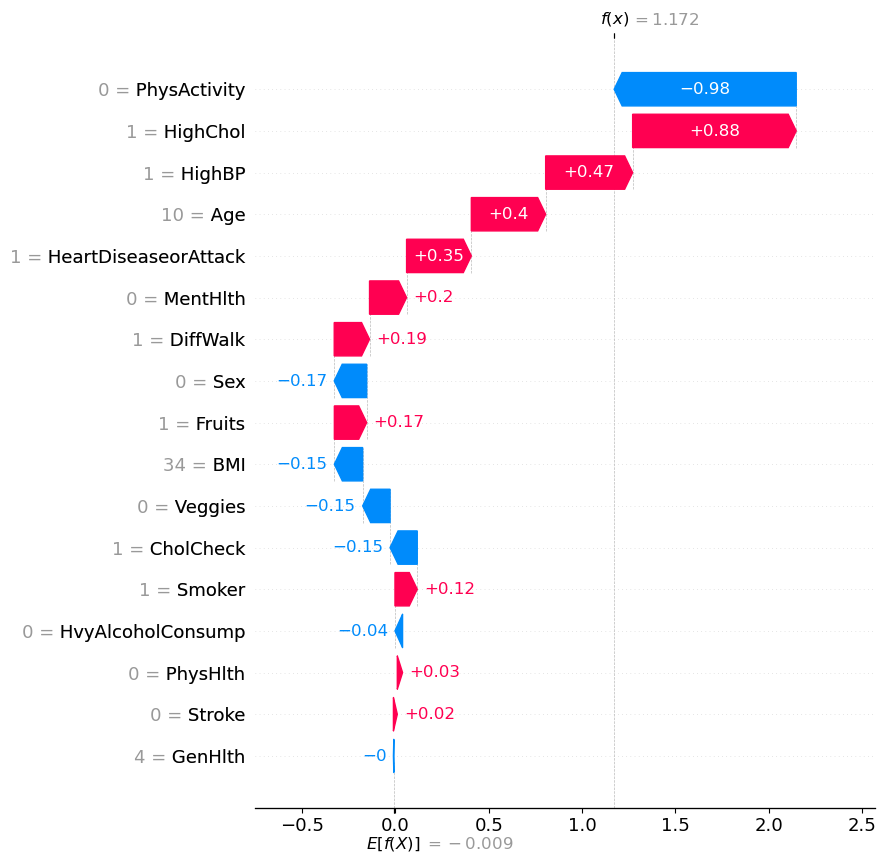

In [16]:
# SHAP values para una instancia particular
idx=1
shap.plots.waterfall(
    shap_values[idx,:],                   
    max_display=17,
)

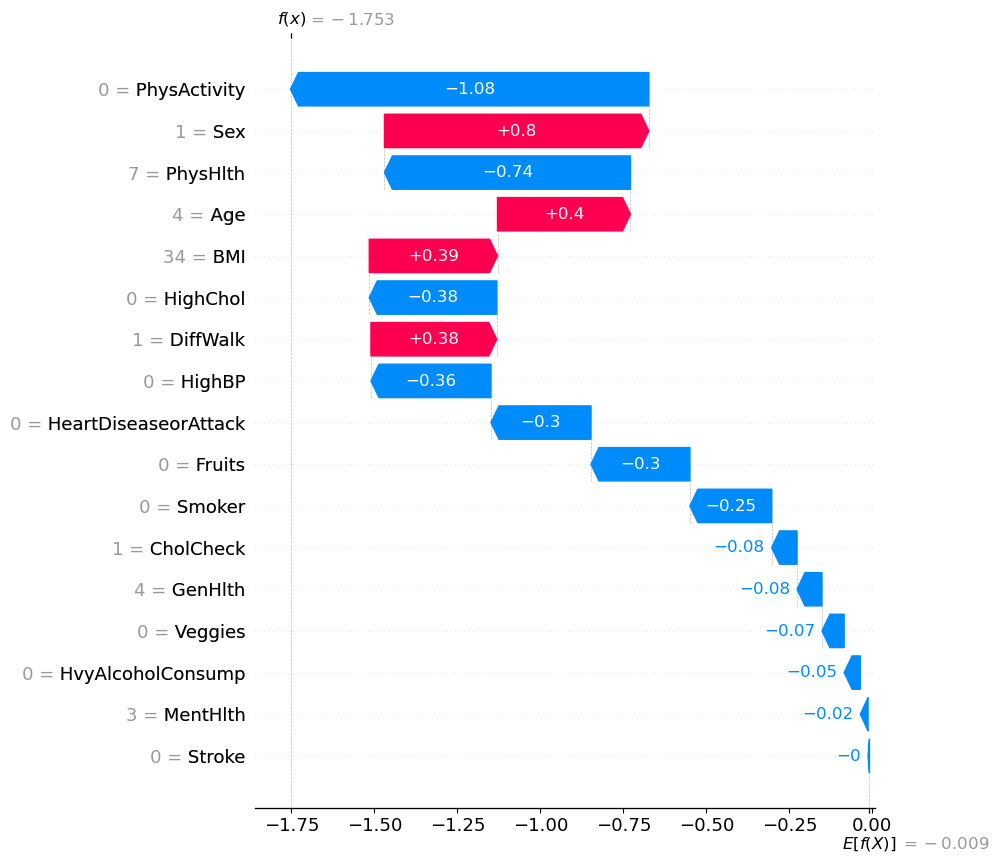

In [17]:
# SHAP values para una instancia particular
idx=9
shap.plots.waterfall(
    shap_values[idx,:],                   
    max_display=17,
)

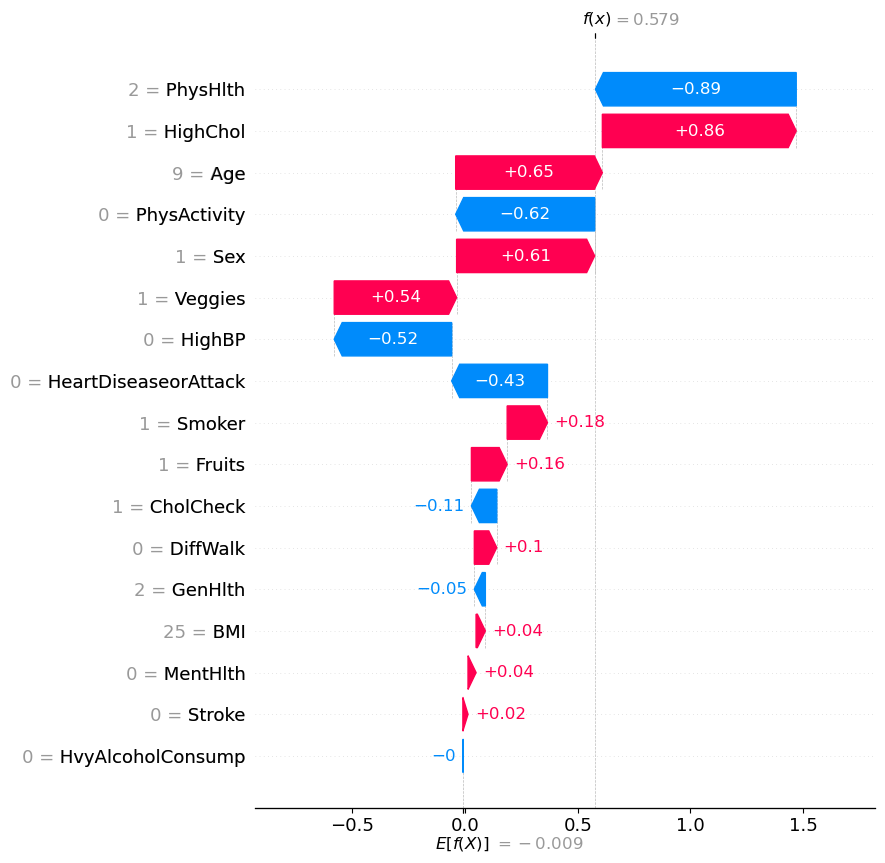

In [18]:
# SHAP values para una instancia particular
idx=150
shap.plots.waterfall(
    shap_values[idx,:],                   
    max_display=17,
)

>Podemos ver que en las tres instancias, las variables HighCol, PhysActivity, Age y PhysHlth aparecen entre las características de mayor impacto, donde HighCol y Age aparecen con un valor positivo, lo que indica que el aumento de HighCol y Age aporta de manera positiva a tener diabetes, mientras que PhysHlth y PhysActivity aparecen con un valor negativo, lo que indica que la ausencia de PhysHlth y PhysActivity aporta de manera positiva a tener diabetes.
>
>Teniendo en cuenta que estas solo son tres instancias particulares, no podemos generalizar este comportamiento para todo el dataset, puesto que también podemos ver que el resto de variables tienen distintos niveles de importancia según la instancia. Más aún, podemos ver que HighCol es positiva en algunas instancias y es negativas en otras, indicando que depende de la instancia individual.

### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

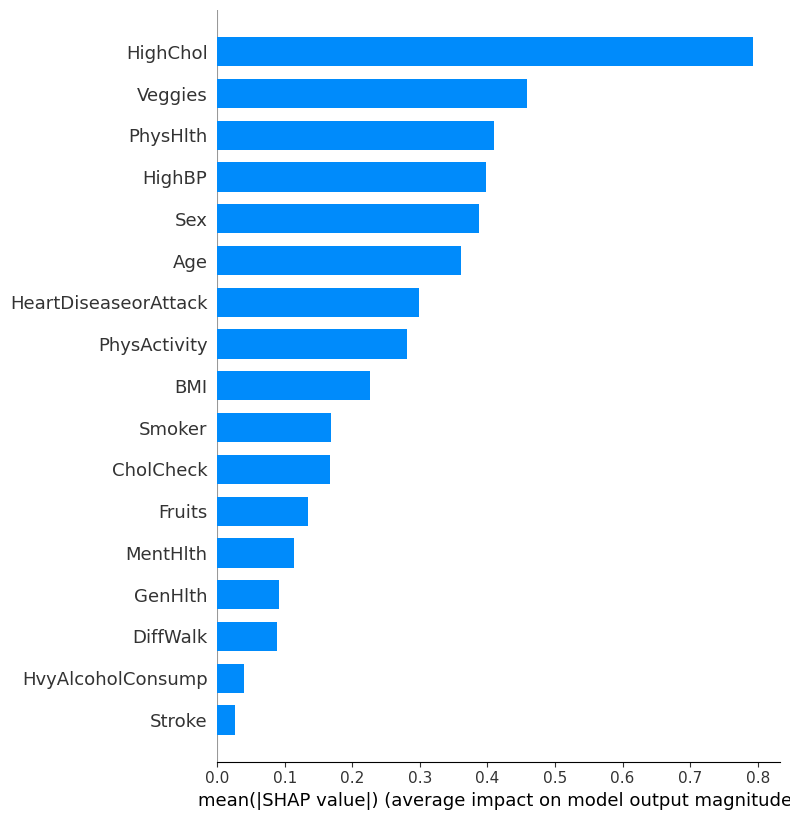

In [19]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

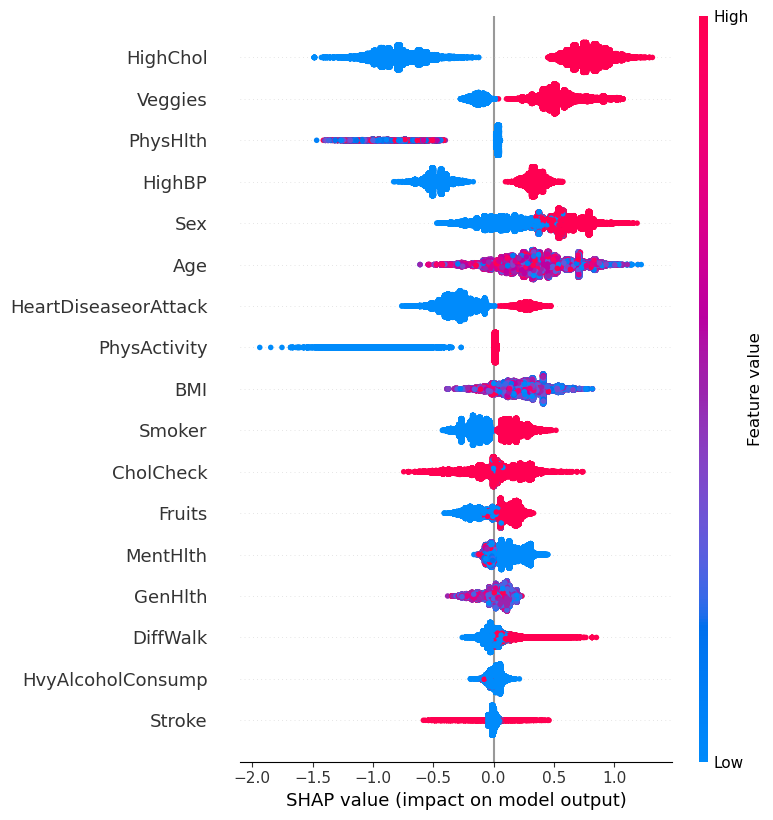

In [20]:
shap.summary_plot(shap_values, X_train)

>En este caso podemos ver que a nivel global las variables HighChol, Veggies y PhysHlth son las más importantes para el modelo, sin embargo, hay muchas instancias que tiene SHAP values negativos y positivos para la variable HighCol, lo que podría indicar que esta variable si bien es importante para el modelo, no entrega una causalidad para la variable objetivo, ya que su valor dependerá de la instancia particular.
>
>Por otro lado, vemos que las variables Veggies y PhysHlth ambas tienden a tener el comportamiento que vimos en las instancias particulares de la parte anterior, por lo que estas variables podrían presentan una mayor relación con la variable objetivo.

### 5.4 Scatter plot (0.4 puntos)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

In [21]:
# obtenemos los shap values
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

# Obtenemos los nombres ordenados de mayor a menor
feature_importance_names = X_train.columns[shap_values_abs.argsort()[::-1]]

# Revisamos las features
feature_importance_names

Index(['HighChol', 'Veggies', 'PhysHlth', 'HighBP', 'Sex', 'Age',
       'HeartDiseaseorAttack', 'PhysActivity', 'BMI', 'Smoker', 'CholCheck',
       'Fruits', 'MentHlth', 'GenHlth', 'DiffWalk', 'HvyAlcoholConsump',
       'Stroke'],
      dtype='object')

In [22]:
feature_importance_names[:5]

Index(['HighChol', 'Veggies', 'PhysHlth', 'HighBP', 'Sex'], dtype='object')

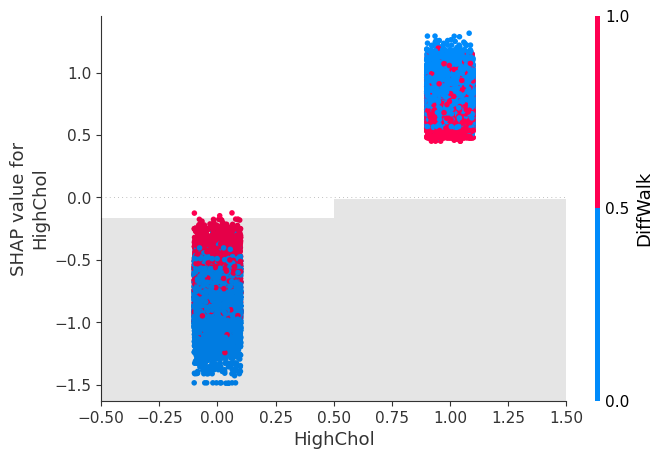

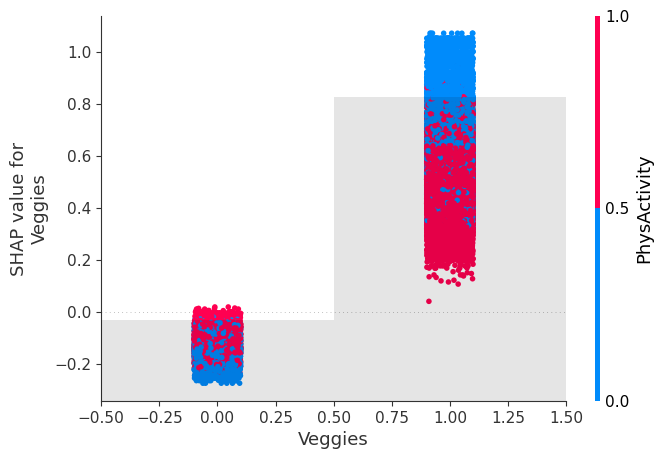

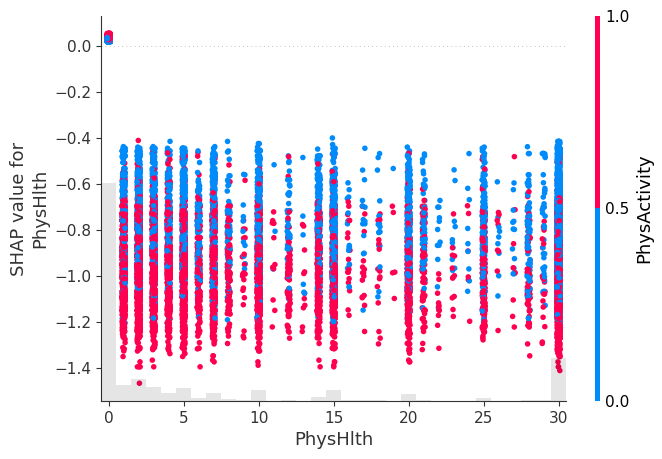

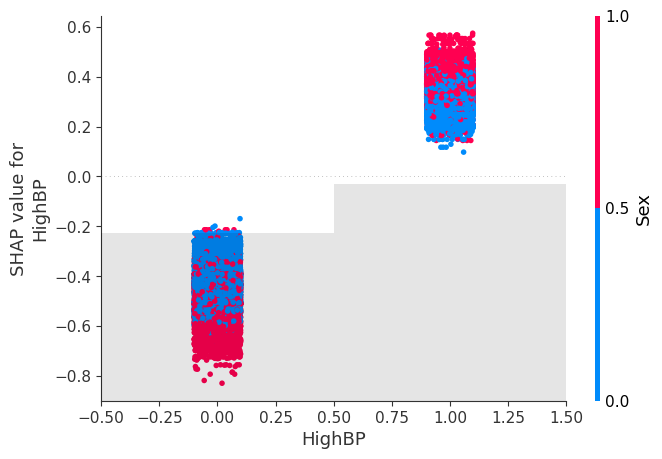

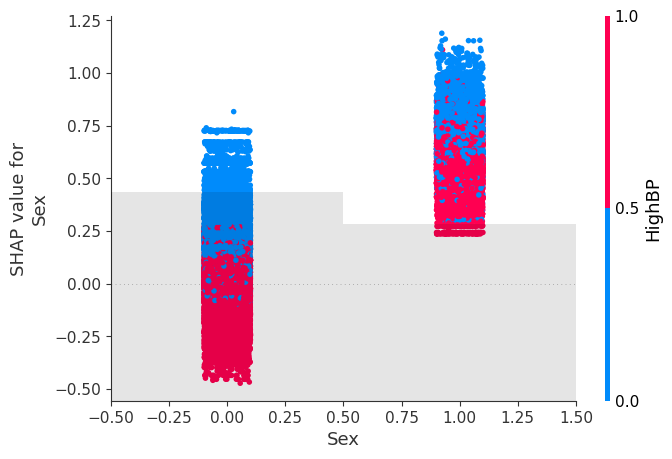

In [23]:
for name in feature_importance_names[:5]:
    shap.plots.scatter(
        shap_values[:,name],         
        color=shap_values
    )

>Podemos ver que los SHAP values tienden a cambiar de signo de negativo a positivo cuando aumentamos el valor de la característica savlo por el gráfico entre PhysHlth y HighBP cuyos valores son en su mayoría negativos. Además vemos que la probabilidad de diabetes tambien aumentan.

### 5.5 Partial Dependence Plot (0.4 puntos)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

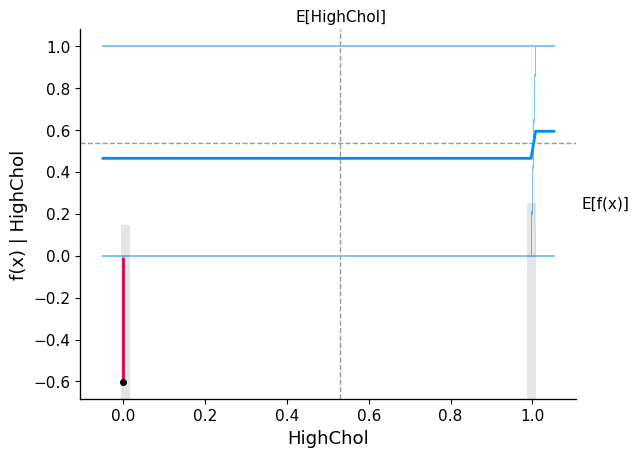

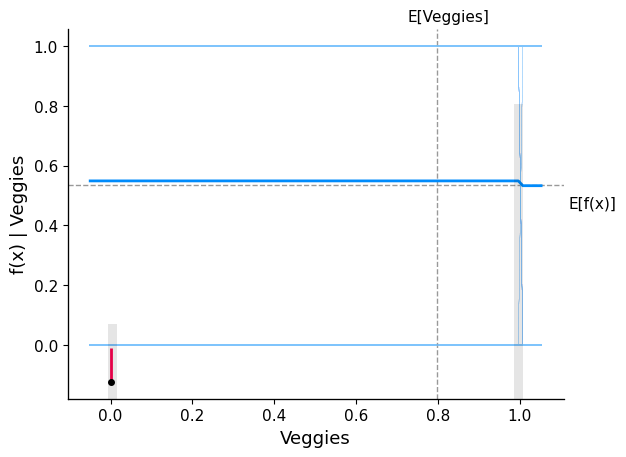

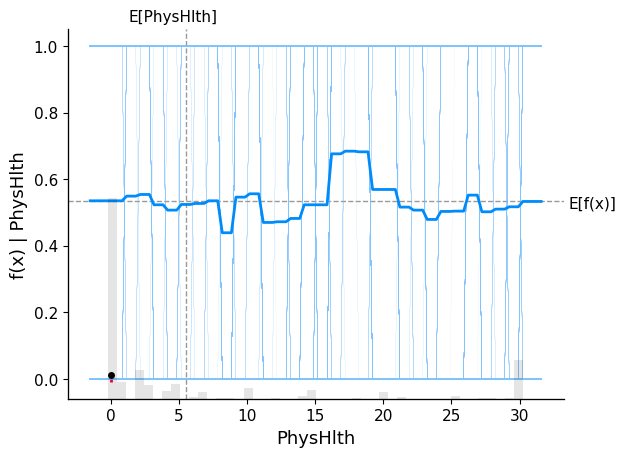

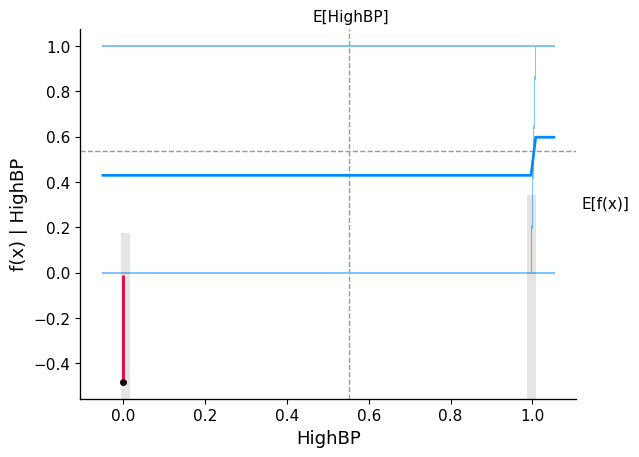

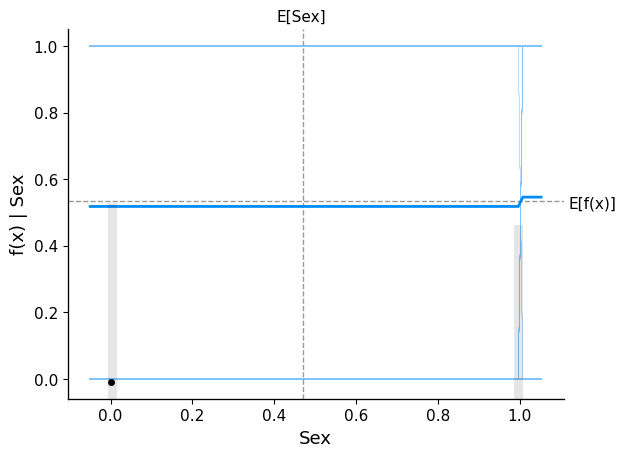

In [24]:
X1000 = shap.utils.sample(X_train, 1000)
sample_ind = 20

for name in feature_importance_names[:5]:
    shap.partial_dependence_plot(
        name, pipeline_xgb.predict, X1000, model_expected_value=True,
        feature_expected_value=True, ice=True,
        shap_values=shap_values[sample_ind:sample_ind+1,:]
    )

>Podemos ver que el valor esperado del modelo se mantiene constante para la mayoría de las características mostradas, lo que indicaría que estas variables no son tan importantes cuando manteenmos el resto constante, sin embargo, al ser variables binarias podemos ver que la probabilidad aumenta cuando cambiamos de un estado a otro. 
>
>Lo interesante se encuentra en la variable PhysHlth, donde vemos que la probabilidad de tener diabetes aumenta hasta cierto punto y luego empieza a decrecer, lo que indicaría que para ciertas valores la probabilidad aumenta mientras que para otros valores la probabilidad disminuye, es decir, esta variable no nos permite concluir información a nivel global y es más dependiente de las instancias individuales.
>
>De todas maneras, recordemos que los PDPs solo nos entregan resultados promedio según la muestra elegida, por lo que no es sencillo extraer información global de los datos a través de estos gráficos.

## 6. Sistema de Reglas! (1.0 puntos)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [25]:
!pip install alibi

In [26]:
from alibi.explainers import AnchorTabular

In [27]:
clf = XGBClassifier()
clf.fit(X_train, y_train)

predict_fn = lambda x: clf.predict(x)
explainer = AnchorTabular(predict_fn, clf.feature_names_in_, seed=seed)
explainer.fit(X_train.to_numpy())

class_names = ["No Diabetes","Diabetes"]

for idx in [1000, 3001, 5751]:
    print('Instancia', idx)
    explanation = explainer.explain(X_test.to_numpy()[idx])
    print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
    print('Anchor: %s' % (' AND '.join(explanation.anchor)))
    print('Precision: %.2f' % explanation.precision)
    print('Coverage: %.2f\n' % explanation.coverage)

Instancia 1000
Prediction:  Diabetes
Anchor: GenHlth > 3.00 AND HighChol > 0.00 AND BMI > 29.00
Precision: 0.99
Coverage: 0.11

Instancia 3001
Prediction:  Diabetes
Anchor: GenHlth > 3.00 AND HeartDiseaseorAttack > 0.00
Precision: 0.98
Coverage: 0.08

Instancia 5751
Prediction:  Diabetes
Anchor: GenHlth > 3.00 AND BMI > 33.00 AND Age > 9.00
Precision: 0.99
Coverage: 0.03



>En este caso, vemos que los 3 anchors presentan una baja cobertura, lo que indica que las explicaciones que podamos obtener de estas tres instancias no puede ser generalizadas, y la población que podemos explicar no es mucha, sin embargo, vemos que la precisión es bastante alta, lo que indica que las explicaciones son exactas, por lo que son útiles para interpretar las instancias individuales.
>
>En conclusión, los anchors entregados son bastante precisos, pero muy específicos, por lo que no es fácil de generalizar al resto de datos. Teniendo en cuenta que queremos obtener un equilibrio entre precisión y cobertura, podríamos intentar flexibilizar más las reglas de forma de poder explicar una población mayor sin perder exactitud.

# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

>De los métodos vistos podemos decir que el análisis de SHAP values nos permitió obtener mejores conclusiones, ya que podíamos interpretar los modelos tanto a nivel global como a nivel de instancias individuales, más aún, se pudo analizar las relaciones entre las características.
>
>Una de las conclusiones que obtuvimos con cada método era que las explicaciones de las instancias individuales no se podían extrapolar a todo el conjunto de datos, lo cual tiene sentido debido a la gran diferencia entre las personas, y las variadas causas que pueden provocar la diabetes, por lo que para el doctor Simi le sería más útil los métodos agnósticos locales, de forma de poder interpretar los resultados de cada paciente de manera específica.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)